<br><br><br><br><br>

# PyROOT: ROOT in Python

<br><br><br><br><br>

<br><br>

<p style="font-size: 1.25em">Show of hands:</p>

   1. Who hasn't heard of ROOT?
   2. Who hasn't heard of PyROOT?
   3. Who hasn't ever used PyROOT?
   4. Who doesn't use PyROOT regularly?

<br><br>

Welcome to JupyROOT 6.17/01


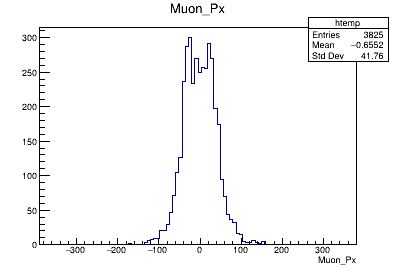

In [1]:
import ROOT                                      # PyROOT

file = ROOT.TFile("data/HZZ.root")               # PyROOT transliterates C++ syntax to Python
tree = file.Get("events")

canvas = ROOT.TCanvas("canvas", "", 400, 300)    # Jupyter-ROOT only: need to create TCanvas
tree.Draw("Muon_Px")
canvas.Draw()                                    # and Draw it to see plots inline

Another Jupyter-ROOT feature: C++ cells!



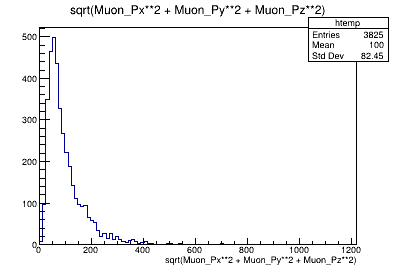

In [2]:
%%cpp

std::cout << "Another Jupyter-ROOT feature: C++ cells!" << std::endl << std::endl;

events->Draw("sqrt(Muon_Px**2 + Muon_Py**2 + Muon_Pz**2)");
canvas->Draw();

In [3]:
%%cpp -d

double define_cpp_functions(double a, double b) {
    return a + b;
}

In [4]:
# ... that you can use on both sides of the divide.

ROOT.define_cpp_functions(3.14, 100)

103.14

In [5]:
# PyROOT's ability to bind any C++ function to Python, without user intervention,
# is unique and far-reaching.
# 
# Even if you're not in Jupyter (i.e. a script running in a batch job), you can use it:

ROOT.gInterpreter.Declare(r"""
double another_cpp_function(double x) {
    return x*x*x;
}
""")

ROOT.another_cpp_function(123)

1860867.0

In [6]:
# Unfortunately, you can't redefine C++ functions, which makes interactive work difficult.
# 
# Here's what I do:

pyname = "cpp_func"
cppname = pyname + "_%d" % sum(1 if x.startswith(pyname) else 0 for x in dir(ROOT))
ROOT.gInterpreter.Declare(r"""

    double """ + cppname + r"""(double x) {
        return x*x;
    }

""")
exec(f"{pyname} = ROOT.{cppname}")

cpp_func(5)

25.0

<img src="img/03-cheat-sheet.png" width="100%">

In [7]:
# Most importantly, you can pass Numpy arrays.
# The bridge might be slow, but you can move a lot of data at once by casting an array,
# then do work on the C++ side.

import numpy
values = numpy.arange(1000001, dtype=numpy.float32)

ROOT.gInterpreter.Declare(r"""
void cpp_on_numpy(int how_many, float* values) {
    for (int i = 0;  i < how_many;  i++) {
        values[i] = sqrt(values[i]);
    }
}
""")

ROOT.cpp_on_numpy(len(values), values)
values

array([   0.       ,    1.       ,    1.4142135, ...,  999.999    ,
        999.9995   , 1000.       ], dtype=float32)

In [8]:
# A raw C array interface is a little dangerous because the wrong len(values) will seg-fault.
# Use std::vectors instead.

a_vector = ROOT.std.vector("float")(1000001)
a_array = numpy.asarray(a_vector)

# a_array is viewing the same data as a_vector: changing one changes the other.
a_array[:] = numpy.arange(1000001, dtype=numpy.float32)

list(a_vector[:10])

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]

<br><br>

<p style="font-size: 2em; font-weight: bold">Reminder:</p>

<br>

<center><img src="img/numpy-memory-layout.png" width="75%"></center>

<br><br>

In [9]:
ROOT.gInterpreter.Declare(r"""
std::vector<double> cpp_on_vector(std::vector<float> &a_vector) {
    std::vector<double> out;
    out.reserve(a_vector.size());
    for (auto x : a_vector) {
        out.push_back(sqrt(x));
    }
    return out;
}
""")

numpy.asarray(ROOT.cpp_on_vector(a_vector))

array([   0.        ,    1.        ,    1.41421354, ...,  999.99902344,
        999.99951172, 1000.        ])

In [10]:
# Unlike arrays created by Numpy, vectors are "owned" by C++.
# They'll stay in memory until deleted in ROOT, and Numpy isn't informed (potential for seg-faults.)

a_array.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

In [11]:
# For example, clearing and shrinking the vector frees its memory for other data to be allocated.
# Numpy doesn't know this and continues to look at those bytes, regardless of what they might contain.
# 
# Accessing the array (e.g. printing on the screen) *might* cause a seg-fault.
# Changing the array values *would likely* cause a seg-fault (or worse: corrupt data).

a_vector.clear()
a_vector.shrink_to_fit()

len(a_vector), a_vector.capacity(), len(a_array)

(0, 0, 1000001)

<br><br><br><br><br>

<p style="font-size: 2em; text-align: center">Processing TTree data</p>

<br><br><br><br><br>

In [12]:
# You can use PyROOT directly:

for i, event in enumerate(tree):
    print([x for x in event.Muon_Px])
    if i > 10:
        break

[-52.89945602416992, 37.7377815246582]
[-0.8164593577384949]
[48.987831115722656, 0.8275666832923889]
[22.08833122253418, 76.6919174194336]
[45.171321868896484, 39.75095748901367]
[9.228110313415527, -5.793715000152588]
[12.538717269897461, 29.541839599609375]
[34.883758544921875]
[-53.16697311401367, 11.491869926452637]
[-67.01485443115234, -18.118755340576172]
[15.983028411865234, 34.68440628051758]
[-70.51190948486328, -38.028743743896484]


<p style="font-size: 1.25em">But you should be aware that this is the slowest thing you can do—considerably slower than Python itself—and I don't know of an easy upgrade path from PyROOT to something faster.</p>

<br>

<center><img src="img/logscales.png" width="75%"></center>

In [13]:
# You can do all the processing in C++ and only drive from Python.

tree.MakeClass("as_a_cpp_project")

0

Info in <TTreePlayer::MakeClass>: Files: as_a_cpp_project.h and as_a_cpp_project.C generated from TTree: events


In [14]:
!cat as_a_cpp_project.h

//////////////////////////////////////////////////////////
// This class has been automatically generated on
// Fri Jun  7 20:26:39 2019 by ROOT version 6.17/01
// from TTree events/
// found on file: data/HZZ.root
//////////////////////////////////////////////////////////

#ifndef as_a_cpp_project_h
#define as_a_cpp_project_h

#include <TROOT.h>
#include <TChain.h>
#include <TFile.h>

// Header file for the classes stored in the TTree if any.

class as_a_cpp_project {
public :
   TTree          *fChain;   //!pointer to the analyzed TTree or TChain
   Int_t           fCurrent; //!current Tree number in a TChain

// Fixed size dimensions of array or collections stored in the TTree if any.

   // Declaration of leaf types
   Int_t           NJet;
   Float_t         Jet_Px[5];   //[NJet]
   Float_t         Jet_Py[5];   //[NJet]
   Float_t         Jet_Pz[5];   //[NJet]
   Float_t         Jet_E[5];   //[NJet]
   Float_t         Jet_btag[5];   //[NJet]
   Bool_t          Jet_ID[5];   //[NJet

In [15]:
# Compile and load the C++

ROOT.gInterpreter.ProcessLine(".L as_a_cpp_project.C++")

# Create an instance
loop = ROOT.as_a_cpp_project()

# Run it!
loop.Loop()

Info in <TUnixSystem::ACLiC>: creating shared library /home/pivarski/talks/2019-06-10-usatlas-argonne-python/as_a_cpp_project_C.so


In [16]:
# But the way that "plays best" with the Python scientific ecosystem is to create Numpy arrays.
# 
# TTree::AsMatrix() is a new function for that:

tree.AsMatrix(["MET_px", "MET_py"])

array([[  5.91277122,   2.5636332 ],
       [ 24.76520348, -16.34910965],
       [-25.78508759,  16.23713112],
       ...,
       [ 18.10164642,  50.29071808],
       [ 79.87519073, -52.35145187],
       [ 19.71374893,  -3.59541821]])

In [17]:
# Use return_labels=True to interface with Pandas.

data, labels = tree.AsMatrix(["MET_px", "MET_py"], return_labels=True)

import pandas
df = pandas.DataFrame(data, columns=labels)
df

,MET_px,MET_py
0,5.912771,2.563633
1,24.765203,-16.349110
2,-25.785088,16.237131
3,8.619896,-22.786547
4,5.393139,-1.310052
5,-3.759475,-19.417021
6,23.962149,-9.049156
7,-57.533348,-20.487679
8,42.416195,-94.350861
9,-1.914469,-23.963034


In [18]:
# But the word "matrix" is to be taken seriously: it is only for one-per-event data.

tree.AsMatrix(["Muon_Px"])

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

Error in <TTreeReaderValueBase::GetBranchDataType()>: Must use TTreeReaderArray to read branch Muon_Px: it contains an array or a collection.
Error in <TTreeReaderValueBase::CreateProxy()>: The branch Muon_Px contains data of type {UNDETERMINED TYPE}, which does not have a dictionary.


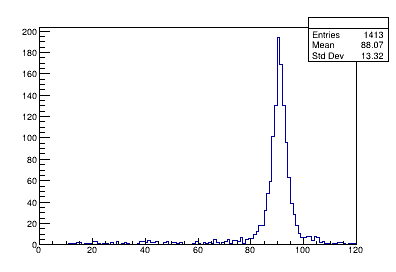

In [19]:
# RDataFrame is ROOT's new preferred way of processing TTrees.
# You can define a dataflow in Python, but the code that runs in each event is in C++ (in the strings).

rdf = ROOT.RDataFrame("events", "data/HZZ.root")
h = (rdf.Filter("NMuon >= 2")
        .Define("zmass", r"""(TLorentzVector(Muon_Px[0], Muon_Py[0], Muon_Pz[0], Muon_E[0]) +
                              TLorentzVector(Muon_Px[1], Muon_Py[1], Muon_Pz[1], Muon_E[1])).M()""")
        .Histo1D(("", "", 120, 0, 120), "zmass"))
h.Draw()
canvas.Draw()

<img src="img/03-coming-soon-2.png" width="100%">